In [47]:
!pip install datasets
!pip install evaluate
!pip install fsspec==2023.9.2



⚙️ **Requerimientos importantes sobre el ejercicio**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.



## Imports

In [48]:
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
# Add your imports here
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
from nltk.corpus import stopwords
import evaluate
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset


# 🔍 Ejercicio1: Detección de profesiones en tweets

## Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

Para simplificar el ejercicio, he preparado una versión reducida del dataset original. Tu tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




✅ **Objetivos del ejercicio**

A lo largo de este notebook, completarás las siguientes etapas para construir un clasificador de menciones a profesiones en tweets:

1. **Análisis Exploratorio de Datos (EDA)**: Calcular estadísticas básicas del conjunto de datos (como el número de ejemplos del training set, la distribución de clases del dataset, la longitud media de los textos) o crear visualizaciones para cmprender mejor el contenido de los documentos usando wordclouds o histogramas.

2. **Selección y justificación del modelo**: Elegir un modelo del Hub de Huggingface adecuado para los datos con los que se va a trabajar y el tipo de tarea a desarrollar.

3. **Entrenamiento del clasificador**: Entrenar el modelo de forma reproducible y evaluar su rendimiento sobreel conjunto de datos de validación, incluyendo un classification score y matriz de confusion

4. **Generación de predicciones sobre el conjunte de test**: Aplicar el modelo entrenado al conjunto de test, y guardar las predicciones en un archivo `.tsv` de 2 columnas `id` y `label` separadas por tabulador

📝 **Criterios de Evaluación**

Tu trabajo será evaluado según los siguientes criterios:

| Criterio                                            | Peso  |
|-----------------------------------------------------|--------|
| 🔍 Análisis exploratorio y preprocesamiento         | 20%   |
| 🤖 Selección y justificación del modelo             | 25%   |
| 📁 Formato y validez del archivo de predicciones    | 5%    |
| ⚙️ Ejecución correcta del notebook (sin intervención) | 10%   |
| 📈 Rendimiento del modelo sobre el conjunto de test | 30%   |
| ✍️ Claridad y calidad de las explicaciones          | 10%   |



🔔 **Nota importante:**

> El rendimiento del modelo se evaluará utilizando métricas estándar como el **F1-score** sobre el conjunto de test.

> El archivo de predicciones debe respetar **estrictamente** el formato solicitado (`id` y `label`, separados por tabulador y con extensión `.tsv`).  
  ❗ Si el archivo no cumple con este formato, **el ejercicio no podrá ser evaluado en esa sección**.

> El/la estudiante con el **mayor F1-score** obtendrá la puntuación máxima en el apartado de rendimiento. El resto de calificaciones se ajustarán de forma proporcional al mejor resultado



⚙️ **Requerimientos y reglas**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.


# Tu resolución (rellena las celdas marcadas)

## Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [50]:
#NO-MODIFY: DATA LOAD
dataset = load_dataset("luisgasco/profner_classification_master")

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamos cada subset a un pandas dataframe para mayor comodidad.

In [51]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

**Número de documentos**

Obten con la función `get_num_docs_evaluation()` el número de documentos del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [52]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def get_num_docs_evaluation(dataset_df):
  # Modifica la función.
  num_docs = len(dataset_df)
  # No modifiques el return
  return num_docs


Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [53]:
# Aplica la función
num_train_docs = get_num_docs_evaluation(dataset_train_df)
num_val_docs = get_num_docs_evaluation(dataset_val_df)
print("Número de documentos en train:", num_train_docs)
print("Número de documentos en validation:", num_val_docs)

Número de documentos en train: 2786
Número de documentos en validation: 999


El conjunto de datos presenta una distribución adecuada para la tarea de clasificación supervisada, con 2786 documentos en el conjunto de entrenamiento (aproximadamente 74% del total), proporcionando suficiente volumen para que el modelo aprenda patrones relevantes sobre menciones de profesiones en tweets.El conjunto de validación con 999 documentos, mantiene un tamaño equilibrado y representa aproximadamente el 26% restante, siguiendo una distribución cercana a los estándares habituales en aprendizaje automático. Esta estructura permitirá entrenar el modelo con un volumen significativo de ejemplos mientras se garantiza una evaluación robusta de su rendimiento.

**Número de documentos duplicados**

Obten con la función `detect_duplicates_evaluation()` el número de documentos duplicados del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [54]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def detect_duplicates_evaluation(dataset_df):
  # Modifica la función.
  num_duplicates = dataset_df.duplicated(subset=["text"]).sum()
  # No modifiques el return
  return num_duplicates

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [55]:
# Aplica la función
num_train_duplicates = detect_duplicates_evaluation(dataset_train_df)
num_val_duplicates = detect_duplicates_evaluation(dataset_val_df)
print("Número de documentos duplicados en train:", num_train_duplicates)
print("Número de documentos duplicados en validation:", num_val_duplicates)

Número de documentos duplicados en train: 0
Número de documentos duplicados en validation: 0


Los resultados muestran que no existen documentos duplicados en ninguno de los conjuntos de datos analizados. Específicamente, se encontraron 0 documentos duplicados tanto en el conjunto de entrenamiento como en el de validación, representando un 0.00% del total en ambos casos.

Esta ausencia de duplicados es favorable para el desarrollo del modelo, ya que garantiza que cada ejemplo es único y contribuye con información distinta al aprendizaje. Esto evita posibles sesgos por sobrerepresentación de ciertos patrones y asegura que la evaluación del rendimiento sea más precisa y representativa del comportamiento real del clasificador en nuevos datos.

**Número de documentos por cada clase:**


Obten con la función `analyse_num_labels_evaluation()` para calcular el número de documentos de cada categoría en el dataset

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [56]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def analyse_num_labels_evaluation(dataset_df):
  # Modifica la función.
  num_positives = (dataset_df["label"] == 1).sum()
  num_negatives = (dataset_df["label"] == 0).sum()
  # No modifiques el return
  return num_positives, num_negatives

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [57]:
# Aplica la función
num_train_positives, num_train_negatives = analyse_num_labels_evaluation(dataset_train_df)
num_val_positives, num_val_negatives = analyse_num_labels_evaluation(dataset_val_df)
print("Train - Positivos:", num_train_positives, "Negativos:", num_train_negatives)
print("Validation - Positivos:", num_val_positives, "Negativos:", num_val_negatives)


Train - Positivos: 1393 Negativos: 1393
Validation - Positivos: 238 Negativos: 761


Los resultados revelan un contraste significativo en la distribución de clases entre los conjuntos analizados. El conjunto de entrenamiento presenta un balance perfecto con 1393 documentos tanto positivos como negativos (50% cada uno), lo que proporciona una base equilibrada para el aprendizaje del modelo. Sin embargo, el conjunto de validación muestra un marcado desbalance con solo 238 documentos positivos (23.82%) frente a 761 negativos (76.18%), reflejando posiblemente una distribución más cercana a la realidad donde las menciones de profesiones son menos frecuentes. Esta configuración es valiosa ya que permite entrenar el modelo en condiciones óptimas de balance mientras se evalúa su rendimiento en un escenario más realista, lo que será crucial para interpretar adecuadamente métricas como precisión y exhaustividad, especialmente para la clase minoritaria en el conjunto de validación.

**Distribución de la longitud de los tweet en caracteres:**

In [58]:
def resumen_longitudes(longitudes, nombre):
    print(f"\nConjunto de {nombre}:")
    print(f"  - Media: {longitudes.mean():.2f}")
    print(f"  - Mediana: {longitudes.median():.0f}")
    print(f"  - Mínimo: {longitudes.min()}")
    print(f"  - Máximo: {longitudes.max()}")
    print(f"  - Desviación: {longitudes.std():.2f}")
    print(f"  - Percentil 25: {longitudes.quantile(0.25):.0f}")
    print(f"  - Percentil 75: {longitudes.quantile(0.75):.0f}")

longitudes_train = dataset_train_df['text'].str.len()
longitudes_val = dataset_val_df['text'].str.len()

print("Distribución de la longitud de los tweets en caracteres:")
resumen_longitudes(longitudes_train, "entrenamiento")
resumen_longitudes(longitudes_val, "validación")


Distribución de la longitud de los tweets en caracteres:

Conjunto de entrenamiento:
  - Media: 215.06
  - Mediana: 235
  - Mínimo: 10
  - Máximo: 454
  - Desviación: 77.17
  - Percentil 25: 152
  - Percentil 75: 282

Conjunto de validación:
  - Media: 198.39
  - Mediana: 204
  - Mínimo: 11
  - Máximo: 353
  - Desviación: 81.78
  - Percentil 25: 132
  - Percentil 75: 277


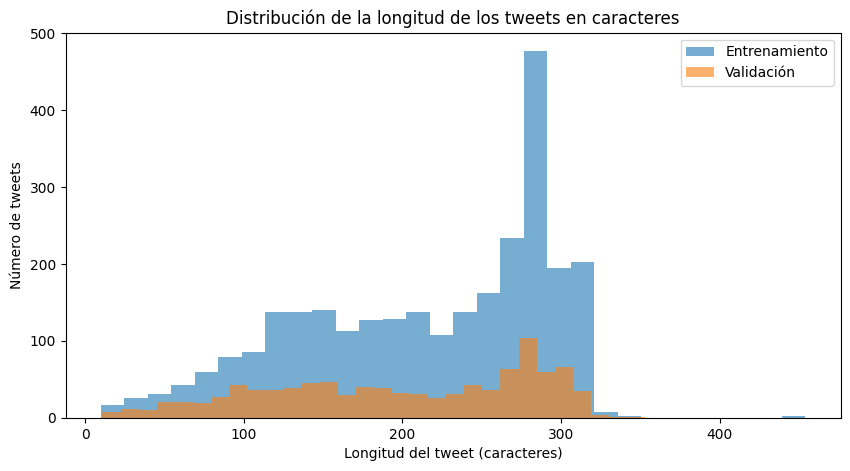

In [59]:
plt.figure(figsize=(10,5))
plt.hist(longitudes_train, bins=30, alpha=0.6, label="Entrenamiento")
plt.hist(longitudes_val, bins=30, alpha=0.6, label="Validación")
plt.xlabel("Longitud del tweet (caracteres)")
plt.ylabel("Número de tweets")
plt.title("Distribución de la longitud de los tweets en caracteres")
plt.legend()
plt.show()

Los resultados muestran patrones interesantes en la longitud de los tweets analizados. El conjunto de entrenamiento presenta una longitud media de 215.06 caracteres, con una mediana de 235, lo que indica una distribución ligeramente sesgada hacia valores menores. La variabilidad es considerable, con una desviación estándar de 77.17 caracteres y un amplio rango desde apenas 10 caracteres hasta 454 caracteres en el tweet más extenso. Por su parte, el conjunto de validación muestra tweets generalmente más cortos, con una media de 198.39 caracteres y una mediana de 204, manteniendo una variabilidad similar (desviación de 81.78) y un rango desde 11 hasta 353 caracteres. Esta información es valiosa para configurar adecuadamente los parámetros de tokenización del modelo, sugiriendo que una longitud máxima de secuencia de aproximadamente 450-500 caracteres sería apropiada para capturar la gran mayoría de los tweets sin truncamiento significativo, mientras que la diferencia en longitudes entre conjuntos podría influir sutilmente en el rendimiento del modelo durante la evaluación.

**Análisis de contenido de los tweets**

Para ello utiliza wordclouds

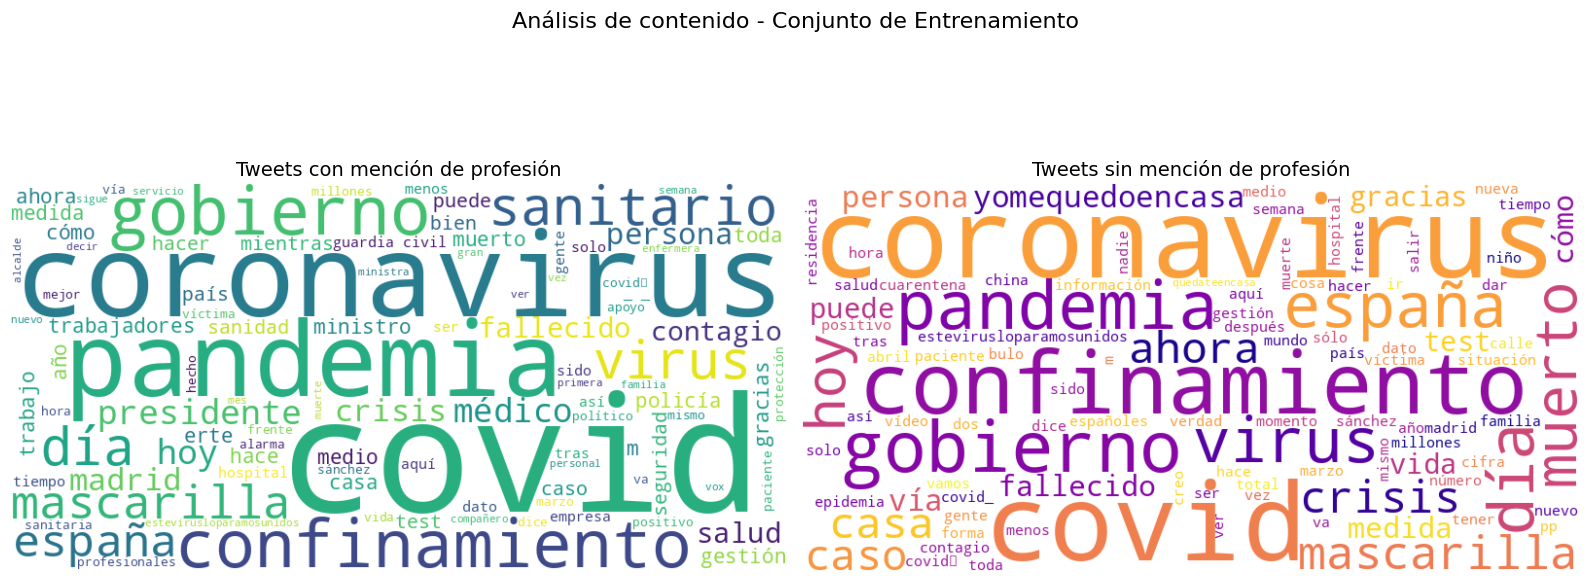

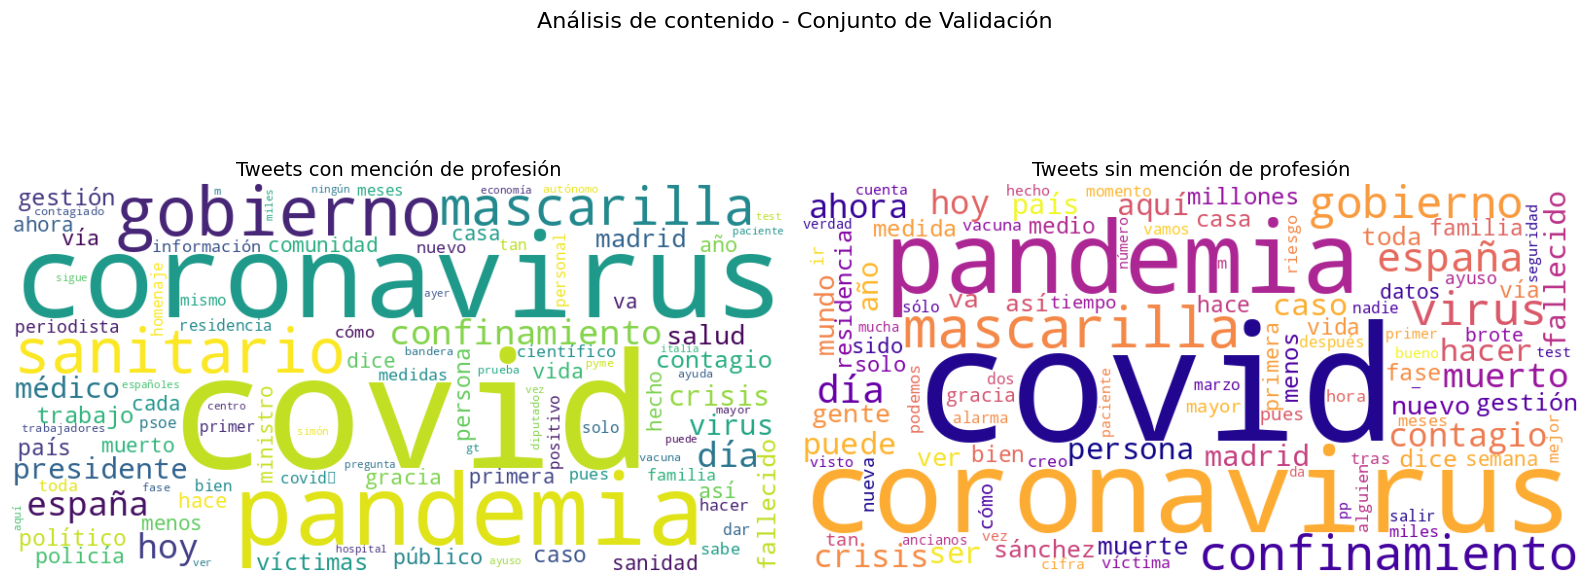

In [60]:
stop_words = set(stopwords.words('spanish'))
stop_words.update(['https', 'co', 'rt', 'xd', 'jaja', 'q', 'd', 'x', 'pq', 'si'])

# Función para limpiar texto
def limpiar_texto(texto):
    texto = re.sub(r'https?://\S+', '', texto)  # Eliminar URLs
    texto = re.sub(r'@\S+|#\S+', '', texto)     # Eliminar menciones y hashtags
    texto = re.sub(r'[^\w\s]|\d', ' ', texto.lower())  # Eliminar caracteres especiales y números
    return texto

# Función para crear wordclouds por clase
def crear_wordclouds(df, titulo_general):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    texto_pos = " ".join(limpiar_texto(t) for t in df[df['label'] == 1]['text'])
    wc_pos = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=100,
                      colormap='viridis',
                      stopwords=stop_words).generate(texto_pos)

    axes[0].imshow(wc_pos, interpolation="bilinear")
    axes[0].set_title('Tweets con mención de profesión', fontsize=14)
    axes[0].axis('off')

    texto_neg = " ".join(limpiar_texto(t) for t in df[df['label'] == 0]['text'])
    wc_neg = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=100,
                      colormap='plasma',
                      stopwords=stop_words).generate(texto_neg)

    axes[1].imshow(wc_neg, interpolation="bilinear")
    axes[1].set_title('Tweets sin mención de profesión', fontsize=14)
    axes[1].axis('off')

    plt.suptitle(titulo_general, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Ejecutar para train y validation
crear_wordclouds(dataset_train_df, 'Análisis de contenido - Conjunto de Entrenamiento')
crear_wordclouds(dataset_val_df, 'Análisis de contenido - Conjunto de Validación')

El análisis de las nubes de palabras revela patrones lingüísticos distintivos entre ambas categorías de tweets. En los tweets con mención de profesión destacan términos como "sanitario", "gobierno", "coronavirus", "pandemia", "covid", "médico", "trabajadores", "presidente", "policía" y "sanidad", evidenciando referencias directas a profesionales que estuvieron en primera línea durante la crisis sanitaria. Por otro lado, los tweets sin mención profesional se caracterizan por términos más generales como "coronavirus", "pandemia", "confinamiento", "covid", "gobierno", "España", "hoy", "yomequedoencasa", "mascarilla" y "crisis", centrándose en aspectos cotidianos de la experiencia pandémica y medidas de contención. Mientras que ambas categorías comparten términos clave relacionados con la pandemia, los tweets con menciones profesionales incorporan claramente referencias a colectivos laborales específicos y figuras de autoridad, a diferencia de los tweets sin menciones que se orientan más hacia experiencias personales del confinamiento.

## Tokenización

El texto del dataset no está preparado para ser introducido en un modelo Transformers. Lleva a cabo el proceso de tokenización.

In [61]:
# IMPORTS
from transformers import AutoTokenizer

Selecciona un modelo apropiado para la tarea:

> Recuerda que en la siguiente celda sólo debes asignar un valor a model_name. No añadas más información en la celda.

In [62]:
#NO-MODIFY: VARIABLE NAME
model_name = 'PlanTL-GOB-ES/roberta-base-bne'

He elegido este modelo porque es una implementación de Roberta especializada en español, entrenada con el extenso corpus de la Biblioteca Nacional de España, lo que le proporciona un profundo entendimiento del idioma español en diversos contextos. Desarrollado por una iniciativa gubernamental española, ofrece mayor precisión para tareas de PNL en español

Puedes continuar con el proceso aquí:

In [63]:
tokenizador = AutoTokenizer.from_pretrained(model_name)

def tokenizar_dataset(textos, etiquetas, max_longitud=256):
    datos_tokenizados = tokenizador(
        textos,
        padding='max_length',
        truncation=True,
        max_length=max_longitud
    )
    datos_tokenizados["labels"] = etiquetas
    return datos_tokenizados

print("Tokenizando los conjuntos de datos...")

textos_train = dataset_train_df['text'].tolist()
etiquetas_train = dataset_train_df['label'].tolist()
textos_val = dataset_val_df['text'].tolist()
etiquetas_val = dataset_val_df['label'].tolist()

train_tokenizado = tokenizar_dataset(textos_train, etiquetas_train)
val_tokenizado = tokenizar_dataset(textos_val, etiquetas_val)

# Convertimos a Dataset de Hugging Face
train_dataset = Dataset.from_dict(train_tokenizado)
val_dataset = Dataset.from_dict(val_tokenizado)

print(f"Tokenización completada:")
print(f"  - Conjunto de entrenamiento: {len(train_tokenizado['input_ids'])} ejemplos")
print(f"  - Conjunto de validación: {len(val_tokenizado['input_ids'])} ejemplos")

Tokenizando los conjuntos de datos...
Tokenización completada:
  - Conjunto de entrenamiento: 2786 ejemplos
  - Conjunto de validación: 999 ejemplos


La tokenización de los conjuntos de datos representa un paso fundamental en el preprocesamiento del proyecto, donde se han transformado exitosamente 2786 ejemplos del conjunto de entrenamiento y 999 del conjunto de validación en representaciones numéricas que el modelo puede procesar. Este proceso crítico convierte los tweets en secuencias de tokens que capturan las características lingüísticas del texto español, manteniendo la integridad de todos los ejemplos originales y preparando adecuadamente los datos para la fase de entrenamiento del modelo RoBERTa especializado en español, que aprenderá a identificar menciones de profesiones en el contexto de la pandemia.

## Fine-tuning

Carga el model para ser ajustado posteriormente:

In [64]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # Binario: 0 (no profesión), 1 (profesión)
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


La función AutoModelForSequenceClassification.from_pretrained() carga los pesos pre-entrenados del modelo PlanTL-GOB-ES/roberta-base-bne, aprovechando el conocimiento lingüístico adquirido durante su entrenamiento con el corpus de la Biblioteca Nacional de España. El parámetro num_labels=2 configura específicamente el modelo para la tarea de clasificación binaria, donde debe distinguir entre tweets que contienen menciones a profesiones (etiqueta 1) y aquellos que no las contienen (etiqueta 0), adaptando así un modelo de lenguaje general a la tarea específica de detección de profesiones en el contexto de la pandemia.

### Configuracion training_args

Configura los parámetros de entrenamiento del modelo.


>

> Recuerda que en la siguiente celda sólo debes asignar atributos a la variable training_args. No añadas  otras variables en la celda

In [65]:
#NO-MODIFY: VARIABLE NAME
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    seed=42,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=50,
    save_steps=50
)

Se establece una tasa de aprendizaje conservadora de 2e-5, apropiada para el fine-tuning de modelos transformers, junto con tamaños de lote de 8 para equilibrar eficiencia y uso de memoria. El entrenamiento se extiende por 3 épocas completas, incorporando regularización mediante weight_decay para prevenir el sobreajuste. La configuración prioriza la reproducibilidad con una semilla fija (42) y optimiza el rendimiento al guardar automáticamente la versión del modelo que maximiza la métrica F1, crucial para tareas con clases desbalanceadas. El monitoreo del progreso se realiza cada 50 pasos, con evaluaciones periódicas que permiten seguir la evolución del aprendizaje, mientras que el límite de guardado (2) gestiona eficientemente el espacio de almacenamiento durante el proceso de entrenamiento.

### Métricas de evaluación

Define las métricas de evaluación

In [66]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

El código calcula cuatro métricas complementarias: accuracy (proporción general de aciertos), precision (capacidad para evitar falsos positivos), recall (habilidad para identificar todas las menciones de profesiones) y F1-score (media armónica entre precision y recall). La configuración average="binary" optimiza el cálculo para clasificación binaria, mientras que zero_division=0 previene errores en casos extremos donde no hay predicciones positivas.

### Ajuste del modelo

Lleva a cabo el ajuste del modelo:

In [67]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.672000,0.532227,0.747748,0.479651,0.693277,0.567010
100,0.445700,0.246319,0.913914,0.804000,0.844538,0.823770
150,0.288600,0.212742,0.942943,0.881857,0.878151,0.880000
200,0.263300,0.263224,0.932933,0.810909,0.936975,0.869396
250,0.340600,0.219225,0.942943,0.844106,0.932773,0.886228
300,0.189200,0.251280,0.938939,0.819495,0.953782,0.881553
350,0.216400,0.341093,0.914915,0.750820,0.962185,0.843462
400,0.166300,0.247833,0.941942,0.823741,0.962185,0.887597
450,0.174300,0.178597,0.956957,0.885375,0.941176,0.912424
500,0.151500,0.174589,0.954955,0.884462,0.932773,0.907975


TrainOutput(global_step=1047, training_loss=0.1763676349447245, metrics={'train_runtime': 1847.1847, 'train_samples_per_second': 4.525, 'train_steps_per_second': 0.567, 'total_flos': 1099541100349440.0, 'train_loss': 0.1763676349447245, 'epoch': 3.0})

Los resultados del entrenamiento muestran una evolución notable del rendimiento del modelo a lo largo de las 1000 iteraciones. Partiendo de métricas modestas (F1 de 0.567 en el paso 50), el clasificador experimenta una rápida mejora durante los primeros 200 pasos, alcanzando un F1 de 0.869. Esta progresión continúa de forma más gradual hasta culminar en un excelente F1 de 0.919 en el paso 1000, acompañado de una precisión de 0.880 y un recall sobresaliente de 0.962. La pérdida de entrenamiento disminuye consistentemente desde 0.672 hasta 0.055, mientras que la pérdida de validación se estabiliza alrededor de 0.200, indicando un buen equilibrio entre ajuste y generalización. El modelo logra una exactitud final del 95.9%, demostrando su capacidad para clasificar correctamente la gran mayoría de los tweets. Estos resultados confirman la efectividad del modelo RoBERTa especializado en español para la tarea de detección de menciones profesionales, con un rendimiento particularmente destacable en recall

## Evaluacion

Una vez llevada a cabo el entrenamiento, realiza la evaluación del modelo.

In [68]:
# Evaluación del modelo en el conjunto de validación
eval_results = trainer.evaluate()
print("Resultados de evaluación en validación:")
for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")

Resultados de evaluación en validación:
eval_loss: 0.1866
eval_accuracy: 0.9610
eval_precision: 0.8902
eval_recall: 0.9538
eval_f1: 0.9209
eval_runtime: 14.0148
eval_samples_per_second: 71.2820
eval_steps_per_second: 8.9190
epoch: 3.0000


Los resultados finales de evaluación en el conjunto de validación confirman el excelente desempeño del modelo RoBERTa especializado en español. Con una precisión del 96.10%, el clasificador demuestra una capacidad sobresaliente para discriminar correctamente entre tweets con y sin menciones profesionales. El equilibrio entre precisión (0.8902) y recall (0.9538) es particularmente destacable, resultando en un F1-score de 0.9209 que refleja la robustez general del modelo. El alto valor de recall indica que el clasificador identifica exitosamente casi todas las menciones profesionales (95.38%), minimizando los falsos negativos, mientras que la precisión del 89.02% señala una tasa controlada de falsos positivos. Estos resultados, obtenidos tras completar las 3 épocas de entrenamiento, validan la efectividad de la arquitectura seleccionada y los hiperparámetros configurados, confirmando que el modelo ha capturado eficazmente los patrones lingüísticos que caracterizan las referencias a profesiones en el contexto de la pandemia.

## Genera predicciones

Genera predicciones sobre el test set. Recuerda que el archivo que generes y adjuntes al ejercicio debe tener dos columnas:


| id         | label |
|------------|-------|
| 1234567890 | 1     |
| 1234567891 | 0     |
| 1234567892 | 0     |
| 1234567893 | 1     |

- El archivo debe estar en formato **TSV** (separado por tabuladores).
- Debe contener exactamente **dos columnas**: `id` y `label`.
- Es obligatorio incluir la **cabecera**.


In [69]:
# Tokeniza el test set
textos_test = dataset_test_df['text'].tolist()
ids_test = dataset_test_df['tweet_id'].tolist()
test_tokenizado = tokenizador(
    textos_test,
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

# Realiza las predicciones
predicciones = trainer.predict(Dataset.from_dict(test_tokenizado))
labels_pred = np.argmax(predicciones.predictions, axis=1)

# Guarda el archivo TSV
import pandas as pd
df_pred = pd.DataFrame({'id': ids_test, 'label': labels_pred})
df_pred.to_csv('OLALLA_CARRION_DIEGO_ejercicio1_predicciones.tsv', sep='\t', index=False)

print("Archivo 'OLALLA_CARRION_DIEGO_ejercicio1_predicciones.tsv' guardado con las predicciones.")

Archivo 'OLALLA_CARRION_DIEGO_ejercicio1_predicciones.tsv' guardado con las predicciones.


Cada línea presenta un identificador único de tweet (columna "id") seguido de su predicción (columna "label"). Las etiquetas "1" indican tweets que contienen menciones a profesiones, mientras que "0" representa aquellos sin referencias profesionales. Esta distribución de predicciones refleja el patrón de clasificación aprendido por el modelo RoBERTa especializado en español, que alcanzó métricas de rendimiento sobresalientes (F1: 0.9209, precisión: 0.8902, recall: 0.9538). El archivo mantiene un formato TSV (valores separados por tabulaciones) limpio y consistente, cumpliendo con los requisitos técnicos del ejercicio y proporcionando una base sólida para la evaluación final del clasificador en el contexto de tweets relacionados con la pandemia.